In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.random import default_rng
from datetime import datetime, timedelta
from scipy import stats

rng = default_rng()

In [2]:
def simulate_trade_arrival(arrival_rate, time_period_minutes):
    """
    Generate trade arrival times using Poisson process
    Returns times in minutes
    """
    trade_time = []
    current_time = 0
    while current_time <= time_period_minutes:
        inter_arrival_time = rng.exponential(1 / arrival_rate) * 60  # Convert hours to minutes
        current_time += inter_arrival_time
        if current_time <= time_period_minutes:
            trade_time.append(current_time)
    return trade_time

In [3]:
def get_lambda_for_simulation_time(simulation_minutes_since_open, base_lambda):
    
    hours_since_open = simulation_minutes_since_open / 60
    
    if 0 <= hours_since_open <= 1:        # 9:30-10:30 AM (opening rush)
        return base_lambda * 3.0
    elif 1 <= hours_since_open <= 1.5:    # 10:30-11:00 AM (post-opening)
        return base_lambda * 1.8
    elif 1.5 <= hours_since_open <= 2.5:  # 11:00 AM-12:00 PM (mid-morning)
        return base_lambda * 1.2
    elif 2.5 <= hours_since_open <= 3.5:  # 12:00-1:00 PM (lunch dip)
        return base_lambda * 0.5
    elif 3.5 <= hours_since_open <= 4.5:  # 1:00-2:00 PM (post-lunch)
        return base_lambda * 1.0
    elif 4.5 <= hours_since_open <= 5.5:  # 2:00-3:00 PM (afternoon)
        return base_lambda * 1.3
    elif 5.5 <= hours_since_open <= 6.5:  # 3:00-4:00 PM (closing rush)
        return base_lambda * 2.8
    else:
        return base_lambda

In [4]:
def minutes_to_time_string(minutes_since_open):
    """Convert minutes since market open to HH:MM:SS format"""
    market_open = datetime.strptime("09:30:00", "%H:%M:%S")
    trade_time = market_open + timedelta(minutes=minutes_since_open)
    return trade_time.strftime("%H:%M:%S")

In [5]:
def generate_trades_for_period(period_length, period_start_time, base_lambda):
    
    current_time = 0  # Time within the period (minutes)
    trades = []
    
    while current_time < period_length:
        current_absolute_time = period_start_time + current_time 
        current_arrival_rate = get_lambda_for_simulation_time(current_absolute_time, base_lambda)
        
        # Generate inter-arrival time in hours, then convert to minutes
        inter_arrival_time_hours = rng.exponential(1 / current_arrival_rate)
        inter_arrival_time_minutes = inter_arrival_time_hours * 60
        
        current_time += inter_arrival_time_minutes
        
        if current_time < period_length:
            absolute_time = period_start_time + current_time
            trades.append(absolute_time)
    
    return trades

In [6]:
def generate_trades_by_period():
    
    total_time = 390  # Total trading minutes (6.5 hours)
    period_length = 60  # 60-minute periods
    time_points = range(0, 390, period_length)
    all_trades_time = []
    
    for start_period in time_points:
        actual_period_length = min(period_length, total_time - start_period)
        base_lambda = 100  # Base arrival rate (trades per hour)
        
        period_trades = generate_trades_for_period(actual_period_length, start_period, base_lambda)
        all_trades_time.extend(period_trades)
        
        period_hour = start_period // 60 + 1
        start_time = minutes_to_time_string(start_period)
        end_time = minutes_to_time_string(start_period + actual_period_length)
        print(f"Period {period_hour} ({start_time}-{end_time}): {len(period_trades)} trades")
    
    return sorted(all_trades_time)

In [7]:
def calculate_inter_arrival_times(trade_times):
    """Calculate time differences between consecutive trades"""
    return np.diff(sorted(trade_times))

In [8]:
def trade_size_generation(alpha, num_trades, max_size=100000, min_size=100):
    """
    Generate trade sizes following power-law distribution
    Uses inverse transform sampling
    """
    if alpha <= 1:
        raise ValueError("Power law alpha must be > 1 for a proper distribution")
    
    u = rng.uniform(0, 1, size=num_trades)
    trade_sizes = min_size * (1 - u) ** (-1 / (alpha - 1))
    trade_sizes = np.clip(trade_sizes, min_size, max_size)
    
    return trade_sizes

In [9]:
def print_trade_times_formatted(trade_times, trade_sizes, max_trades=20):
    
    print(f"\nFirst {min(max_trades, len(trade_times))} trade times:")
    for i, trade_time in enumerate(trade_times[:max_trades]):
        time_str = minutes_to_time_string(trade_time)
        print(f"Trade {i+1:2d}: {time_str} ({trade_time:.2f} min) | Size: {trade_sizes[i]:,.2f}")
    
    if len(trade_times) > max_trades:
        print(f"... and {len(trade_times) - max_trades} more trades")


In [10]:
def print_inter_arrival_analysis(trade_times):
    """Analyze and print inter-arrival time statistics"""
    inter_arrivals = calculate_inter_arrival_times(trade_times)
    
    print(f"\n=== INTER-ARRIVAL TIME ANALYSIS ===")
    print(f"Total trades: {len(trade_times)}")
    print(f"Inter-arrival times: {len(inter_arrivals)}")
    print(f"Mean inter-arrival time: {np.mean(inter_arrivals):.3f} minutes")
    print(f"Std dev inter-arrival time: {np.std(inter_arrivals):.3f} minutes")
    print(f"Min inter-arrival time: {np.min(inter_arrivals):.3f} minutes")
    print(f"Max inter-arrival time: {np.max(inter_arrivals):.3f} minutes")
    print(f"Median inter-arrival time: {np.median(inter_arrivals):.3f} minutes")


In [11]:
def generate_trade_direction(num_trades):
    
    return rng.choice([-1, 1], size=num_trades) #-1 : sell
                                                #1 : buy


In [12]:

def price_movement(trade_sizes, trade_direction, mean=0, volatility=0.001, base_price=100):
    """
    Generate price evolution with market impact
    Enhanced with more realistic price dynamics
    """
    beta = 0.01  # Market impact parameter
    avg_trade_size = np.mean(trade_sizes)
    n_trades = len(trade_sizes)
    
    prices = np.zeros(n_trades + 1)
    prices[0] = base_price
    
    for idx in range(n_trades):
        size = trade_sizes[idx]
        direction = trade_direction[idx]
        
        # Random price movement
        epsilon = rng.normal(mean, volatility)
        
        # Market impact based on trade size
        size_impact = beta * np.log(size / avg_trade_size)
        
        # Combined price change
        price_change = direction * size_impact * epsilon
        
        # Apply price change (multiplicative to avoid negative prices)
        prices[idx + 1] = prices[idx] * (1 + price_change)
    
    return prices

In [13]:
print("\nGenerating trades for the entire trading day...")
all_trades = generate_trades_by_period()

num_trades=len(all_trades)

trade_size=trade_size_generation(1.5 , num_trades)
# Print formatted results
print_trade_times_formatted(all_trades , trade_size)
print_inter_arrival_analysis(all_trades)

directions=generate_trade_direction(num_trades)
prices=price_movement(trade_size , directions)

print(prices[:21])

print("==Price Analysis==")

print("Final Price:", prices[-1])
print("Mean Price:", np.mean(prices))
print("Std Dev:", np.std(prices))





Generating trades for the entire trading day...
Period 1 (09:30:00-10:30:00): 335 trades
Period 2 (10:30:00-11:30:00): 164 trades
Period 3 (11:30:00-12:30:00): 70 trades
Period 4 (12:30:00-13:30:00): 81 trades
Period 5 (13:30:00-14:30:00): 115 trades
Period 6 (14:30:00-15:30:00): 189 trades
Period 7 (15:30:00-16:00:00): 133 trades

First 20 trade times:
Trade  1: 09:30:08 (0.14 min) | Size: 119.29
Trade  2: 09:30:13 (0.23 min) | Size: 134.71
Trade  3: 09:30:21 (0.35 min) | Size: 249.54
Trade  4: 09:30:32 (0.54 min) | Size: 63,096.47
Trade  5: 09:30:33 (0.55 min) | Size: 12,084.11
Trade  6: 09:30:43 (0.72 min) | Size: 263.68
Trade  7: 09:30:49 (0.83 min) | Size: 2,689.04
Trade  8: 09:30:52 (0.88 min) | Size: 23,444.36
Trade  9: 09:31:34 (1.57 min) | Size: 4,258.80
Trade 10: 09:31:47 (1.79 min) | Size: 2,581.30
Trade 11: 09:31:51 (1.86 min) | Size: 401.95
Trade 12: 09:32:03 (2.05 min) | Size: 242.16
Trade 13: 09:32:12 (2.20 min) | Size: 148.10
Trade 14: 09:32:14 (2.24 min) | Size: 1,039

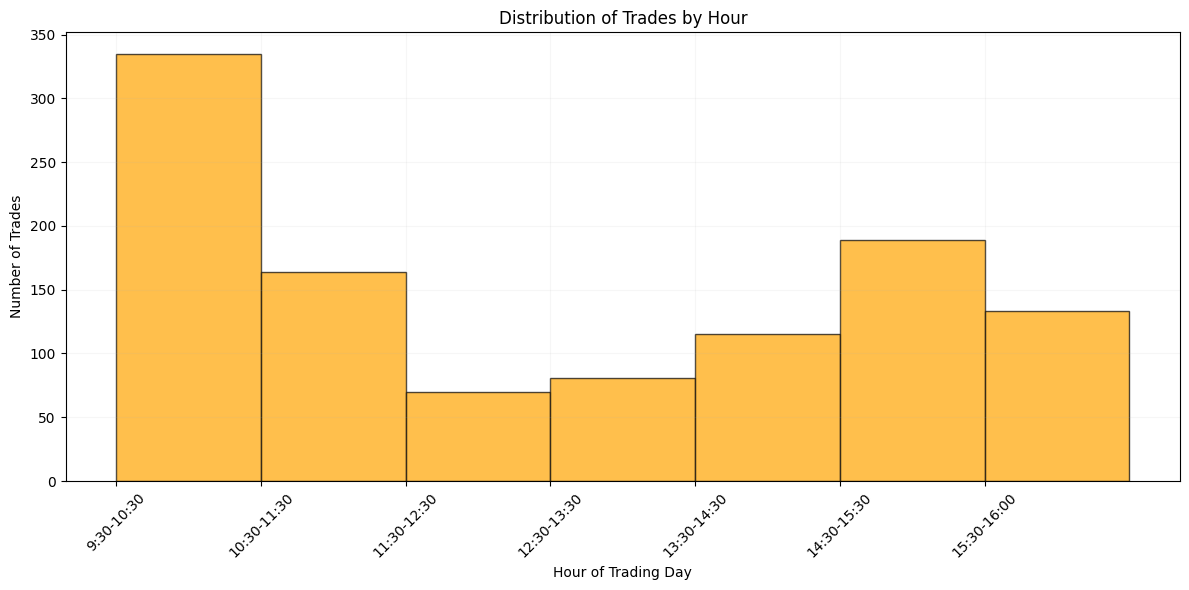


Total trades generated: 1087


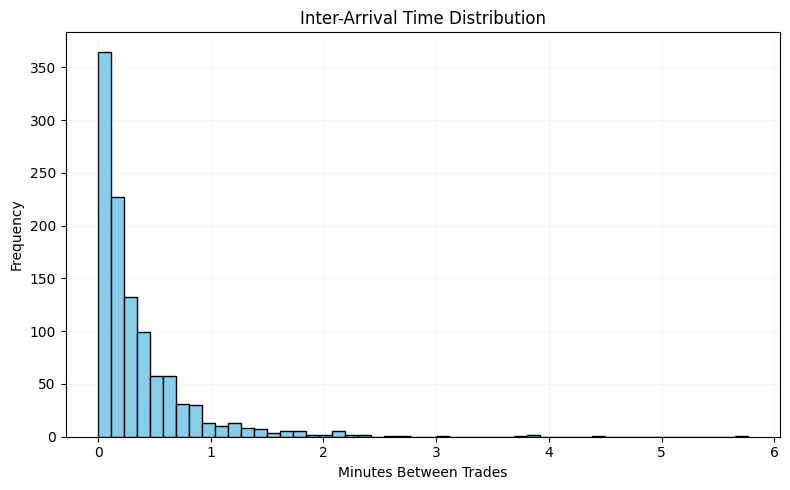

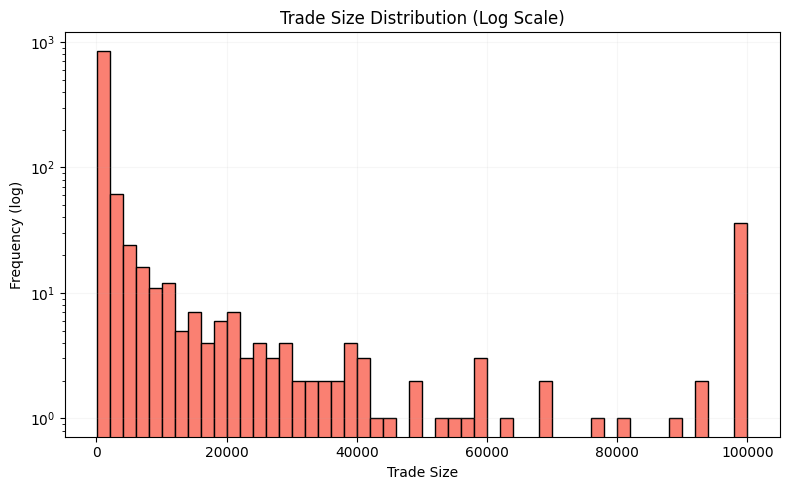

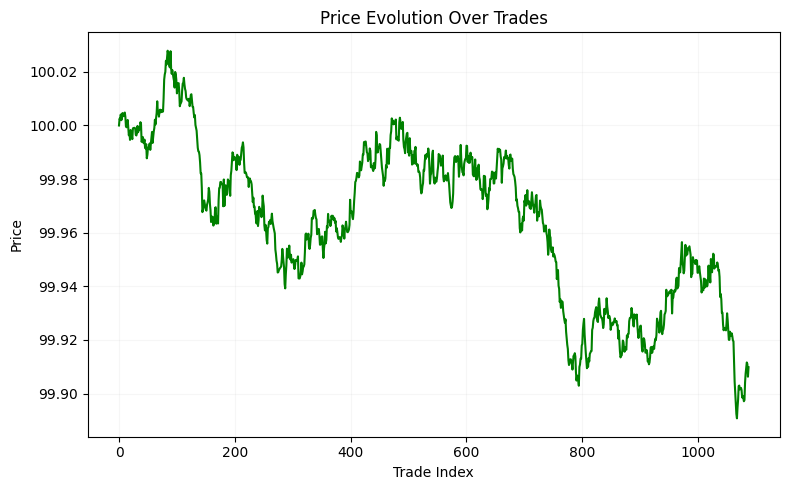

In [14]:
# trades for each hour
plt.figure(figsize=(12, 6))
trade_hours = [int(t // 60) for t in all_trades]
plt.hist(trade_hours, bins=range(8), alpha=0.7, edgecolor='black' , color='orange')
plt.xlabel('Hour of Trading Day')
plt.ylabel('Number of Trades')
plt.title('Distribution of Trades by Hour')
plt.xticks(range(7), ['9:30-10:30', '10:30-11:30', '11:30-12:30', '12:30-13:30', '13:30-14:30', '14:30-15:30', '15:30-16:00'])
plt.xticks(rotation=45)
plt.grid(True, alpha=0.1)
plt.tight_layout()
plt.show()

print(f"\nTotal trades generated: {len(all_trades)}")


# histogram for inter-arrival times
inter_arrival_times = calculate_inter_arrival_times(all_trades)

plt.figure(figsize=(8, 5))
plt.hist(inter_arrival_times, bins=50, color='skyblue', edgecolor='black')
plt.title("Inter-Arrival Time Distribution")
plt.xlabel("Minutes Between Trades")
plt.ylabel("Frequency")
plt.grid(True , alpha=0.1)
plt.tight_layout()
plt.show()

# histogram for trade size
plt.figure(figsize=(8, 5))
plt.hist(trade_size, bins=50, color='salmon', edgecolor='black', log=True)
plt.title("Trade Size Distribution (Log Scale)")
plt.xlabel("Trade Size")
plt.ylabel("Frequency (log)")
plt.grid(True ,  alpha=0.1)
plt.tight_layout()
plt.show()

# Price Evolution
plt.figure(figsize=(8, 5))
plt.plot(prices, color='green')
plt.title("Price Evolution Over Trades")
plt.xlabel("Trade Index")
plt.ylabel("Price")
plt.grid(True , alpha=0.1)
plt.tight_layout()
plt.show()


In [15]:
from scipy.stats import kstest, expon
import numpy as np

def ks_test_exponential(inter_arrivals, label):
    """Perform K-S test and print simplified interpretation"""
    scale = np.mean(inter_arrivals)
    ks_stat, p_val = kstest(inter_arrivals, 'expon', args=(0, scale))
    
    result = (
        "Fits exponential well."
        if p_val > 0.05 else
        "Deviates from exponential (reject null)."
    )
    
    print(f"\nK–S Test: {label}")
    print(f"   Mean : {scale:.4f}, K–S Stat: {ks_stat:.4f}, p-value: {p_val:.4f}")
    print(f"  {result}")

# Test full dataset (expected to fail due to mixed λ)
ks_test_exponential(calculate_inter_arrival_times(all_trades), "Full Day (Mixed λ)")

# Define intervals and labels (hour bins)
intervals = list(zip(
    [0, 60, 120, 180, 240, 300, 360],
    [60, 120, 180, 240, 300, 360, 390],
    ["9:30–10:30", "10:30–11:30", "11:30–12:30",
     "12:30–13:30", "13:30–14:30", "14:30–15:30", "15:30–16:00"]
))

for start, end, label in intervals:
    trades = [t for t in all_trades if start <= t < end]
    if len(trades) > 2:
        ks_test_exponential(calculate_inter_arrival_times(trades), f"Interval {label}")
    else:
        print(f"\nInterval {label}: Not enough trades for test.")



K–S Test: Full Day (Mixed λ)
   Mean : 0.3590, K–S Stat: 0.0746, p-value: 0.0000
  Deviates from exponential (reject null).

K–S Test: Interval 9:30–10:30
   Mean : 0.1792, K–S Stat: 0.0411, p-value: 0.6112
  Fits exponential well.

K–S Test: Interval 10:30–11:30
   Mean : 0.3594, K–S Stat: 0.0602, p-value: 0.5740
  Fits exponential well.

K–S Test: Interval 11:30–12:30
   Mean : 0.8317, K–S Stat: 0.1024, p-value: 0.4360
  Fits exponential well.

K–S Test: Interval 12:30–13:30
   Mean : 0.7309, K–S Stat: 0.0745, p-value: 0.7382
  Fits exponential well.

K–S Test: Interval 13:30–14:30
   Mean : 0.5228, K–S Stat: 0.0685, p-value: 0.6327
  Fits exponential well.

K–S Test: Interval 14:30–15:30
   Mean : 0.3146, K–S Stat: 0.0697, p-value: 0.3068
  Fits exponential well.

K–S Test: Interval 15:30–16:00
   Mean : 0.2267, K–S Stat: 0.0703, p-value: 0.5086
  Fits exponential well.


Calculating best minimal value for power law fit


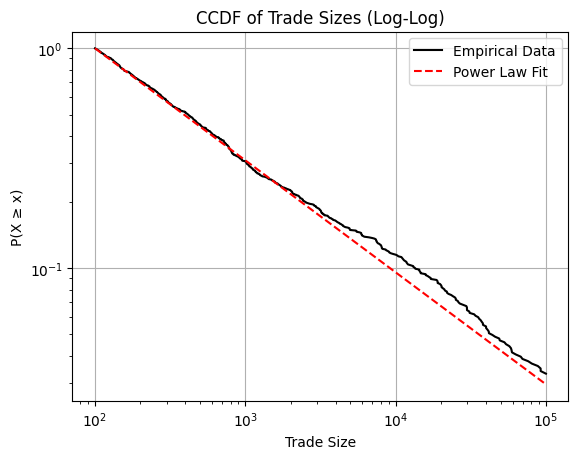

In [20]:

import powerlaw
fit = powerlaw.Fit(trade_size)
fig = fit.plot_ccdf(color='black', label='Empirical Data')
fit.power_law.plot_ccdf(ax=fig, color='red', linestyle='--', label='Power Law Fit')
plt.legend()
plt.title("CCDF of Trade Sizes (Log-Log)")
plt.xlabel("Trade Size")
plt.ylabel("P(X ≥ x)")
plt.grid(True)
plt.show()


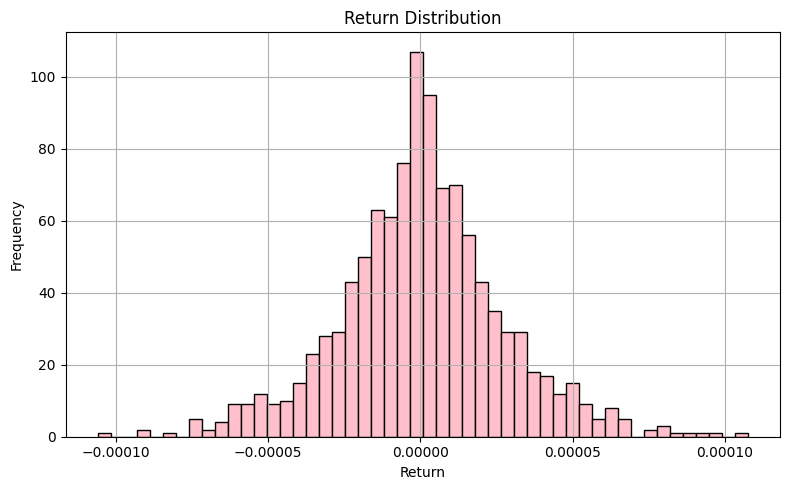

In [ ]:
# Returns
returns = np.diff(prices) / prices[:-1]
plt.figure(figsize=(8, 5))
plt.hist(returns, bins=50, color='pink', edgecolor='black')
plt.title("Return Distribution")
plt.xlabel("Return")
plt.ylabel("Frequency")
plt.tight_layout()
plt.grid(True)
plt.show()


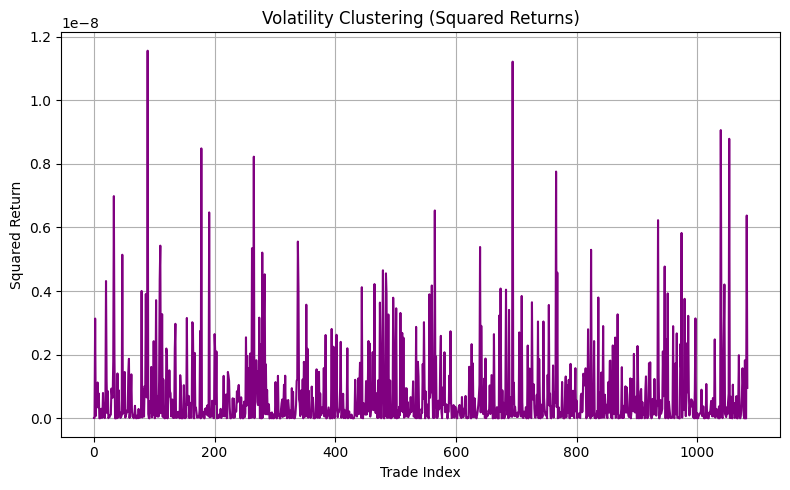

In [ ]:
# volatility clustering
plt.figure(figsize=(8, 5))
plt.plot(np.square(returns), color='purple')
plt.title("Volatility Clustering (Squared Returns)")
plt.xlabel("Trade Index")
plt.ylabel("Squared Return")
plt.tight_layout()
plt.grid(True)
plt.show()


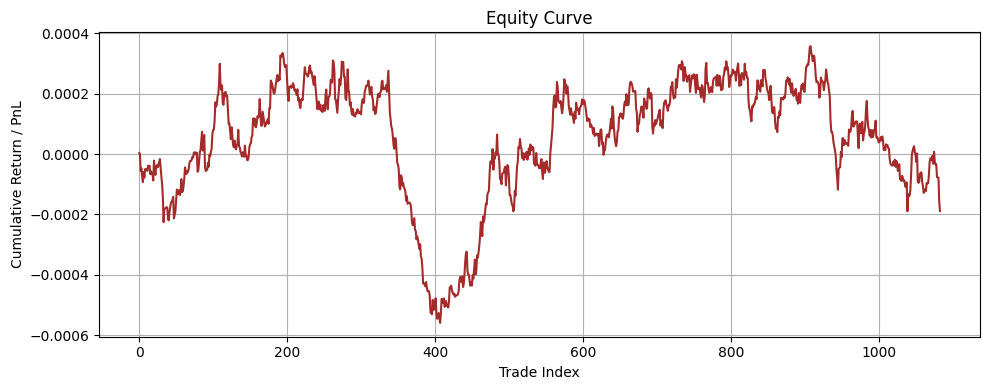

In [ ]:
# equity curve

pnl=directions*returns

# Cumulative PnL (equity curve)
equity = np.cumsum(pnl)

# Plot
plt.figure(figsize=(10, 4))
plt.plot(equity, color='brown')
plt.title("Equity Curve")
plt.xlabel("Trade Index")
plt.ylabel("Cumulative Return / PnL")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
expected_trades = np.sum([get_lambda_for_simulation_time(t, 100) /60 for t in range(390)])
print(f"Expected trades (approx): {expected_trades:.2f}")
print(f"Simulated trades: {len(all_trades)}")


Expected trades (approx): 1070.33
Simulated trades: 1084
